In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np

In [2]:
# study_id = 'aef31aeb7b4d9dde43779738b42be454dc0ede19'
study_id = "aef34cc4d24c162f4f87becb74515e392560de19"

In [3]:
raw_query = '''SELECT SDV."partId", SDV."devicePartId" as "devPartId", tde."deviceInfo", tde."id", "modified", "created"
from "StudyDetailsView" SDV
JOIN "TapDevice" tde on SDV."tapDeviceId" = tde."id"
where SDV."studyId"=?;'''
df = db.raw_query(raw_query, params=[study_id])
df['days'] = (df['modified'] - df['created'] ) / 1000 / 3600 / 24
df.head()

,partId,devPartId,deviceInfo,id,modified,created,days
0,138e0586800e1def47f497cb59d46d4558a928eb,8sd88a8d8abfd8114a37b6b1e75a8251a80012ka,"{""androidVersion"":""6.0"",""deviceManufacturer"":""...",10dd4470-c10a-4426-8af2-0ab62077944c,1553472004179,1550573433499,33.548272
1,138ea99843a8832a4e0681de7ac90cf5b9fc28eb,8sd8b76cb591af2e4c2ba8613e2da694a14812ka,"{""androidVersion"": ""8.1.0"", ""deviceManufacture...",23aa6efb-437d-40d1-954f-2842eefc5017,1545170165609,1545148727017,0.248132
2,138ede2f95a7c24f4ca4acb1834fc35b0ea428eb,8sd8403099f0f437483287748a23eaff640712ka,"{""androidVersion"":""9"",""deviceManufacturer"":""Xi...",26534aed-5c9b-40ce-818d-ddf9dbe92207,1553076684710,1550497882738,29.847245
3,138e059694a0b6144ff8846eaf5d5ae09bc228eb,8sd8837a1243b03c472ba7e3b626d3c5b35f12ka,"{""androidVersion"": ""7.1.2"", ""deviceManufacture...",3df0a2c2-9237-48e6-8804-18196e130739,1545241926621,1545227530294,0.166624
4,138e059694a0b6144ff8846eaf5d5ae09bc228eb,8sd8837a1243b03c472ba7e3b626d3c5b35f12ka,"{""androidVersion"": ""7.1.2"", ""deviceManufacture...",3df0a2c2-9237-48e6-8804-18196e130739,1545241926621,1545227530294,0.166624


In [88]:
df[df["days"] < 90]["days"]

0      59.517814
4       3.787738
5       3.787738
6       2.165670
8      30.915635
         ...    
473    21.902469
474     0.834635
475    21.021720
476     0.015985
479     0.626169
Name: days, Length: 275, dtype: float64

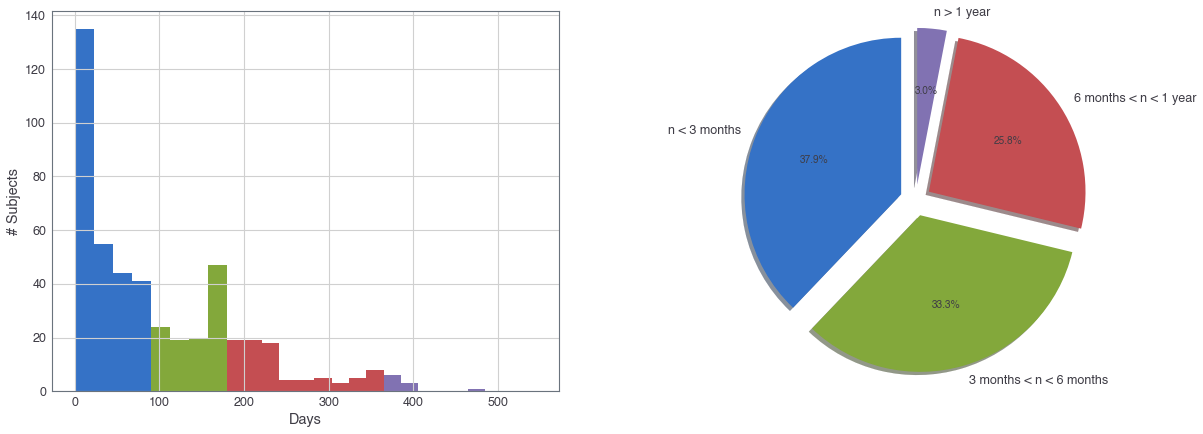

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
# df["days"].hist(bins=30, ax=ax[0])
df[df["days"] < 90]["days"].hist(bins=np.linspace(0, 90, 5), ax=ax[0])
df[(df["days"] >= 90) & (df["days"] < 180)]["days"].hist(bins=np.linspace(90, 180, 5), ax=ax[0])
df[(df["days"] >= 180) & (df["days"] < 365)]["days"].hist(bins=np.linspace(180, 365, 10), ax=ax[0])
df[df["days"] >= 365]["days"].hist(bins=np.linspace(365, 545, 10), ax=ax[0])

ax[0].set_xlabel("Days")
ax[0].set_ylabel("# Subjects")
count_days = Counter()

for i in df['days'].values:
    if i > 365:
        count_days["n > 1 year"] += 1
        continue
    if i > 180:
        count_days["6 months < n < 1 year"] += 1
        continue
    if i > 90:
        count_days["3 months < n < 6 months"] += 1
        continue
    if i > 30:
        count_days["n < 3 months"] += 1
        continue
labels = list(count_days.keys())
sizes = list(count_days.values())
explode = (0.1, 0.1, 0.1, 0.1)  

ax[1].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[1].axis('equal');

In [7]:
summary = loadmat('summary_study.mat')['all_Data_ids']

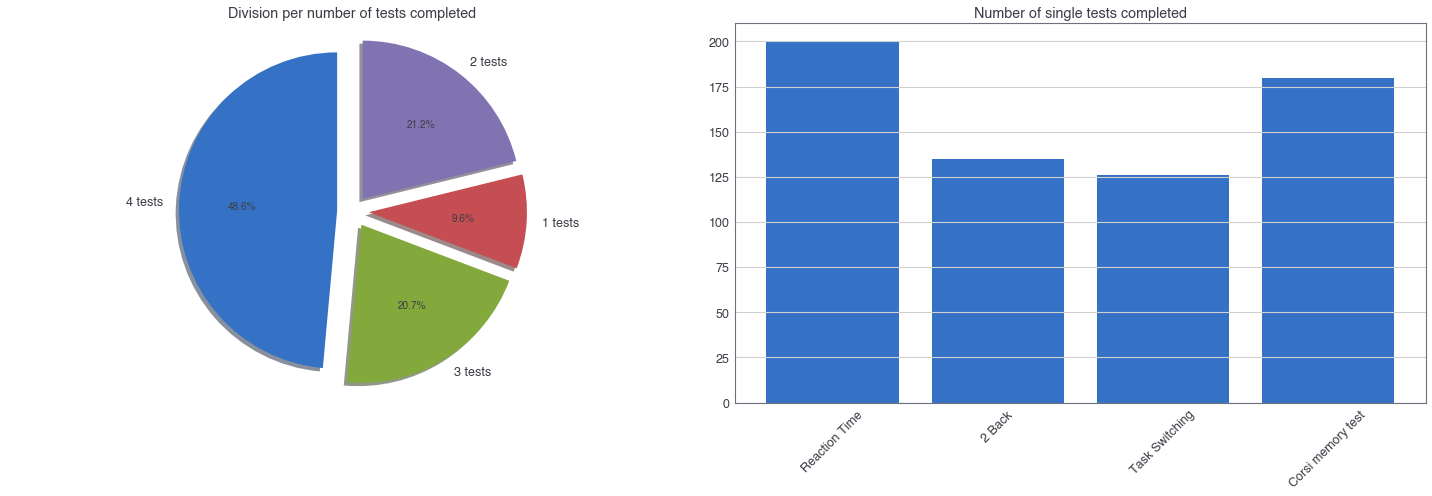

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
# percentage of tests done 
test_dict = Counter([s[6][0][0] for s in summary])
# Pie chart
labels = [f"{k} tests" for k in test_dict.keys() if k != 0]
sizes = [v for k, v in test_dict.items() if k != 0]
explode = (0.1, 0.1, 0.1, 0.1)  

ax[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].axis('equal')  

num_per_test = Counter()

for row in summary:
    if len(row[2][0]) > 0:
        num_per_test['Reaction Time'] += 1
    if len(row[3][0]) > 0:
        num_per_test['2 Back'] += 1
    if len(row[4][0]) > 0:
        num_per_test['Task Switching'] += 1
    if len(row[5][0]) > 0:
        num_per_test['Corsi memory test'] += 1

labels = list(num_per_test.keys())
sizes = list(num_per_test.values())
sizes = np.array(sizes)
barlist = ax[1].bar([0, 1, 2, 3], sizes)
ax[1].set_xticks([0, 1, 2, 3])
ax[1].set_xticklabels(labels, rotation=45)
ax[1].grid(axis='x')
# barlist[1].set_color('r')
# barlist[2].set_color('g')
# barlist[3].set_color('m')
ax[0].set_title("Division per number of tests completed")
ax[1].set_title("Number of single tests completed")
plt.tight_layout()

In [147]:
# sessions
sessions_dict = {"Reaction Time": [], "2-Back": [], "Task Switching": [], "Corsi memory test": []}
for row in summary:
    if (len(row[2][0]) > 0) and (len(row[2][0][0]) > 1):
        sessions_dict["Reaction Time"].append(len(row[2][0][0][1][0]))
    if (len(row[3][0]) > 0) and (len(row[3][0][0]) > 1):
        sessions_dict["2-Back"].append(len(row[3][0][0][1][0]))
    if (len(row[4][0]) > 0) and (len(row[4][0][0]) > 1):
        sessions_dict["Task Switching"].append(len(row[4][0][0][1][0]))
    if (len(row[5][0]) > 0) and (len(row[5][0][0]) > 1):
        sessions_dict["Corsi memory test"].append(len(row[5][0][0][1][0]))

def session_to_dict(sessions):
    _dict = {"1": 0, "2-3": 0, "4-5": 0, "> 5": 0}
    for r in sessions:
        if r > 5:
            _dict['> 5'] += 1
            continue
        if r > 3:
            _dict['4-5'] += 1
            continue
        if r > 1:
            _dict['2-3'] += 1
            continue
        _dict["1"] += 1
    return _dict

rt_dict = session_to_dict(sessions_dict["Reaction Time"])
back2_dict = session_to_dict(sessions_dict["2-Back"])
task_dict = session_to_dict(sessions_dict["Task Switching"])
corsi_dict = session_to_dict(sessions_dict["Corsi memory test"])

In [148]:
rt_dict

{'1': 93, '2-3': 63, '4-5': 15, '> 5': 17}

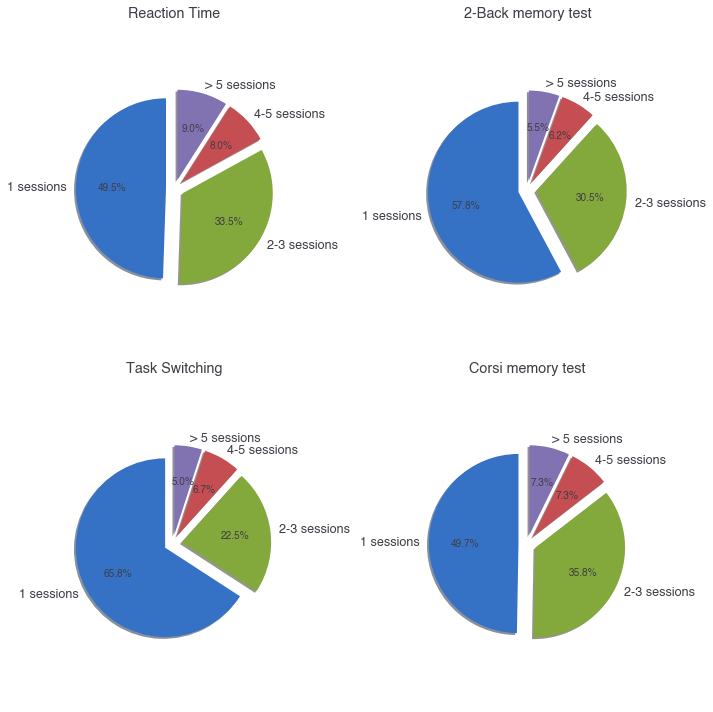

In [156]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# percentage of tests done 
for i, (_dict, _title) in enumerate(zip([rt_dict, back2_dict, task_dict, corsi_dict], 
                              ["Reaction Time", "2-Back memory test", "Task Switching", "Corsi memory test"])):
    # Pie chart
    labels = [f"{k} sessions" for k in _dict.keys() if k != 0]
    sizes = [v for k, v in _dict.items() if k != 0]
    explode = (0.1, 0.1, 0.1, 0.1)  

    ax[i//2, i % 2].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax[i//2, i % 2].axis('equal')  
    ax[i//2, i % 2].set_title(_title)
    
plt.tight_layout()

In [4]:
sessions = db.get_sessions('f9df72f3-9925-409f-8027-4ac066476ac5')
sessions.head()

,id,taps,start,stop,orientations,appIds0,appIds1,appIds2,timeZone,tapsSession,lengthSession,inCharge,created,modified,tapDeviceId
0,510779d0-c370-11eb-853a-1f91227a0127,[],1.622617e+12,1.622617e+12,[],[],[],[],GMT+1:0,0,0,2,1622617272813,1622617272813,f9df72f3-9925-409f-8027-4ac066476ac5
1,510752c0-c370-11eb-853a-1f91227a0127,[],1.622617e+12,1.622617e+12,[],[],[],[],GMT+1:0,0,0,2,1622617272812,1622617272812,f9df72f3-9925-409f-8027-4ac066476ac5
2,5106dd90-c370-11eb-853a-1f91227a0127,"[1622616678128, 1622616678271, 1622616678409, ...",1.622617e+12,1.622617e+12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 1...",GMT+1:0,106,42444,0,1622617272809,1622617272809,f9df72f3-9925-409f-8027-4ac066476ac5
3,51057e00-c370-11eb-853a-1f91227a0127,"[1622614625824, 1622614630392, 1622614636658, ...",1.622615e+12,1.622615e+12,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[21, 21, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9...",GMT+1:0,465,724685,0,1622617272800,1622617272800,f9df72f3-9925-409f-8027-4ac066476ac5
4,5e232290-c36b-11eb-87fc-d1474b6c2a21,[],1.622614e+12,1.622614e+12,[],[],[],[],GMT+1:0,0,0,0,1622615147321,1622615147321,f9df72f3-9925-409f-8027-4ac066476ac5


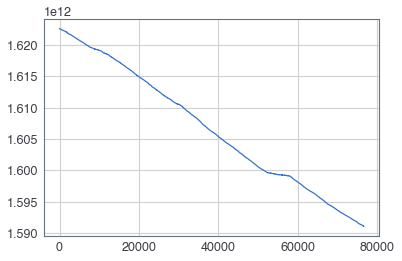

In [37]:
JIDa = qa.dt_dt(sessions, hours=1)
print(JIDa.shape)

  0%|          | 2/8755 [00:00<07:56, 18.39it/s]

(1591097127147.0, 1622616828311.0, 8755, 3600000)


100%|██████████| 8755/8755 [04:37<00:00, 31.60it/s]


(8755, 50, 50)


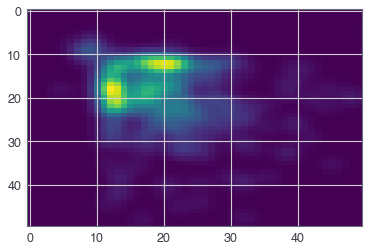

In [38]:
plt.imshow(JIDa[261], aspect='auto')

In [41]:
per = []
for i in range(50):
    for j in range(50): 
        _per, _ = qa.periodgram(JIDa[:, i, j])
        per.append(_per)

In [42]:
savemat('some_JID.mat', {'JIDa': JIDa, 'somePE': np.array(per)})

In [175]:
def dt_to_JID(taps_times, BINS = 50, MIN_H = 1.5, MAX_H = 5):
    some_dt = np.diff(taps_times)  # in ms
    
    xx, yy = np.mgrid[MIN_H : MAX_H : BINS * 1j, MIN_H : MAX_H : BINS * 1j]
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

    log_dt1, log_dt2 = np.log10(np.array(some_dt[:-1]) + eps), np.log10(np.array(some_dt[1:]) + eps)
    xy_train  = np.vstack([log_dt1, log_dt2]).T
    kde_skl = KernelDensity(bandwidth=0.1)
    kde_skl.fit(xy_train)
    z = np.exp(kde_skl.score_samples(xy_sample))
    dt_dt= np.reshape(z, xx.shape)
    
    return dt_dt

In [179]:
from sklearn.neighbors import KernelDensity
eps = 1e-8
taps = sorted(taps)

jid = dt_to_JID(taps)
savemat('some_taps.mat', {"taps": taps, "jid": jid})
print(jid.shape)

(50, 50)


In [27]:
study_id = 'aef333cc3597c660421091c3f4d8ecb4e809de19' # COOLS

In [28]:
# download all the study data
raw_query = '''SELECT 
tde."id" as "dataId",
SDV."devicePartId" as "devPartId",
tde."taps",
tde."start",
tde."stop",
tde."orientations",
tde."appIds0",
tde."appIds1",
tde."appIds2",
tde."timeZone",
tde."tapsSession",
tde."inCharge",
tde."lengthSession",
tde."created" as "dataCreated"
from "StudyDetailsView" SDV
JOIN "TapDataParsed" tde on SDV."tapDeviceId" = tde."tapDeviceId"
where SDV."studyId"=?;'''
df = db.raw_query(raw_query, params=[study_id])
df.head(5)

,dataId,devPartId,taps,start,stop,orientations,appIds0,appIds1,appIds2,timeZone,tapsSession,inCharge,lengthSession,dataCreated
0,cebfeb30-9957-11ea-8683-aba02fe87dc9,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,"[1565726466005, 1565726466839, 1565726467691, ...",1.565726e+12,1.565727e+12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...",GMT+1:0,27,0,97885,1589841299811
1,cebfc420-9957-11ea-8683-aba02fe87dc9,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,"[1565726160456, 1565726161726, 1565726165721, ...",1.565726e+12,1.565726e+12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",GMT+1:0,179,0,266272,1589841299810
2,cec0fca0-9957-11ea-8683-aba02fe87dc9,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,[],1.565729e+12,1.565729e+12,[],[],[],[],GMT+1:0,0,0,0,1589841299818
3,cec03950-9957-11ea-8683-aba02fe87dc9,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,"[1565726607895, 1565726620351, 1565726621561, ...",1.565727e+12,1.565727e+12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...",GMT+1:0,369,0,709691,1589841299813
4,cec123b0-9957-11ea-8683-aba02fe87dc9,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,[1565728903662],1.565729e+12,1.565729e+12,[1],[1],[3],[10],GMT+1:0,1,0,0,1589841299819


In [29]:
len(list(set(df["devPartId"])))

191

In [30]:
df2 = df.drop_duplicates("dataId")

In [31]:
len(df), len(df2)

(1874641, 1626150)

In [32]:
df2.to_csv("leiden_university_study_25_05_2021.csv", index=False)

In [21]:
df3 = pd.read_csv('/media/Storage/Common_Data_Storage/TAP/raw/tapDataParsed_cools_aef34cc4d24c162f4f87becb74515e392560de19_20210525.csv')
print(len(df3))

155934


In [22]:
df4 = df3.drop_duplicates("dataId")
print(len(df4))

154650


In [25]:
df4.sort_values("start").head(3)

,dataId,devPartId,taps,start,stop,orientations,appIds0,appIds1,appIds2,timeZone,tapsSession,inCharge,lengthSession,dataCreated
3101,e1f79bd0-23d1-11eb-b384-fd65151ead5c,8sd8e33f77330c7a47889bf9c8a05b4240bf12ka,"[1524759234526,1524759238451,1524759239432,152...",1.524759e+12,1.524759e+12,"[1,1,1,1,1]","[1,2,2,4,4]","[2,1,1,2,2]","[3,3,3,1,1]",GMT+1:0,5,0,11159,1605066991117
3103,e1f7c2e0-23d1-11eb-b384-fd65151ead5c,8sd8e33f77330c7a47889bf9c8a05b4240bf12ka,"[1524760823310,1524760824452,1524760825260,152...",1.524761e+12,1.524761e+12,"[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1...","[5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5...","[4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4...","[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2...",GMT+1:0,162,0,116675,1605066991118
3102,e1f7e9f0-23d1-11eb-b384-fd65151ead5c,8sd8e33f77330c7a47889bf9c8a05b4240bf12ka,[],1.524762e+12,1.524762e+12,[],[],[],[],GMT+1:0,0,0,0,1605066991119


In [26]:
df2.sort_values("start").head(3)

,DATAID,devPartId,taps,start,stop,orientations,appIds0,appIds1,appIds2,timeZone,tapsSession,inCharge,lengthSession,dataCreated
129091,e1f79bd0-23d1-11eb-b384-fd65151ead5c,8sd8e33f77330c7a47889bf9c8a05b4240bf12ka,"[1524759234526, 1524759238451, 1524759239432, ...",1.524759e+12,1.524759e+12,"[1, 1, 1, 1, 1]","[1, 2, 2, 4, 4]","[2, 1, 1, 2, 2]","[3, 3, 3, 1, 1]",GMT+1:0,5,0,11159,1605066991117
129093,e1f7c2e0-23d1-11eb-b384-fd65151ead5c,8sd8e33f77330c7a47889bf9c8a05b4240bf12ka,"[1524760823310, 1524760824452, 1524760825260, ...",1.524761e+12,1.524761e+12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",GMT+1:0,162,0,116675,1605066991118
129092,e1f7e9f0-23d1-11eb-b384-fd65151ead5c,8sd8e33f77330c7a47889bf9c8a05b4240bf12ka,[],1.524762e+12,1.524762e+12,[],[],[],[],GMT+1:0,0,0,0,1605066991119
